In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [4]:
GROUP_NUMBER = 2
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)


In [5]:
N = 3000

# Uniformly sample points in a square
X = np.random.uniform(-5, 5, (N, 2))
r = np.sqrt(X[:, 0]**2 + X[:, 1]**2)

# True labels
y = ((r >= 2) & (r <= 4)).astype(np.float32)

# Add 5% label noise
noise_idx = np.random.choice(N, size=int(0.05 * N), replace=False)
y[noise_idx] = 1 - y[noise_idx]

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=GROUP_NUMBER
)


In [6]:
def init_layer(in_dim, out_dim):
    W = torch.randn(in_dim, out_dim) * 0.1
    b = torch.zeros(out_dim)
    W.requires_grad = True
    b.requires_grad = True
    return W, b

W1, b1 = init_layer(2, 16)
W2, b2 = init_layer(16, 16)
W3, b3 = init_layer(16, 16)
W4, b4 = init_layer(16, 1)

def relu(z):
    return torch.clamp(z, min=0)

def sigmoid(z):
    return 1 / (1 + torch.exp(-z))

def forward(X):
    z1 = X @ W1 + b1
    a1 = relu(z1)
    z2 = a1 @ W2 + b2
    a2 = relu(z2)
    z3 = a2 @ W3 + b3
    a3 = relu(z3)
    z4 = a3 @ W4 + b4
    y_hat = sigmoid(z4)
    return y_hat

def bce_loss(y_hat, y):
    eps = 1e-7
    y_hat = torch.clamp(y_hat, eps, 1 - eps)
    return -(y * torch.log(y_hat) + (1 - y) * torch.log(1 - y_hat)).mean()

def accuracy(y_hat, y):
    preds = (y_hat >= 0.5).float()
    return (preds == y).float().mean().item()


In [7]:
lr = 0.05
epochs = 800

train_losses, val_losses = [], []
train_accs, val_accs = [], []

params = [W1, b1, W2, b2, W3, b3, W4, b4]

for epoch in range(epochs):
    # ---- TRAIN ----
    y_hat = forward(X_train)
    loss = bce_loss(y_hat, y_train)
    loss.backward()

    with torch.no_grad():
        for p in params:
            p -= lr * p.grad
            p.grad.zero_()

    train_losses.append(loss.item())
    train_accs.append(accuracy(y_hat, y_train))

    # ---- VALIDATION ----
    with torch.no_grad():
        y_val_hat = forward(X_val)
        val_loss = bce_loss(y_val_hat, y_val)
        val_losses.append(val_loss.item())
        val_accs.append(accuracy(y_val_hat, y_val))

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Train Loss {loss.item():.4f} | Val Loss {val_loss.item():.4f}")


Epoch 0 | Train Loss 0.6906 | Val Loss 0.6897
Epoch 100 | Train Loss 0.6632 | Val Loss 0.6645
Epoch 200 | Train Loss 0.6610 | Val Loss 0.6626
Epoch 300 | Train Loss 0.6601 | Val Loss 0.6616
Epoch 400 | Train Loss 0.6588 | Val Loss 0.6601
Epoch 500 | Train Loss 0.6570 | Val Loss 0.6579
Epoch 600 | Train Loss 0.6542 | Val Loss 0.6544
Epoch 700 | Train Loss 0.6497 | Val Loss 0.6488


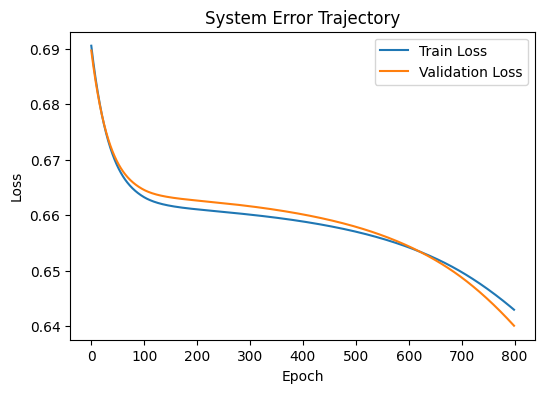

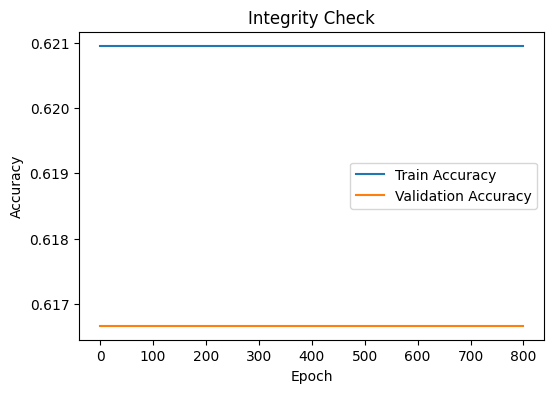

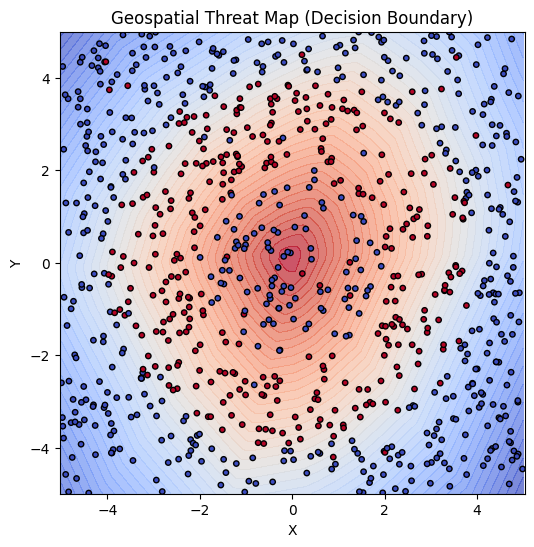

In [8]:
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("System Error Trajectory")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Integrity Check")
plt.show()

# Create mesh grid
xx, yy = np.meshgrid(
    np.linspace(-5, 5, 400),
    np.linspace(-5, 5, 400)
)

grid = torch.tensor(
    np.c_[xx.ravel(), yy.ravel()],
    dtype=torch.float32
)

with torch.no_grad():
    probs = forward(grid).reshape(xx.shape)

plt.figure(figsize=(6,6))
plt.contourf(xx, yy, probs, levels=50, cmap="coolwarm", alpha=0.7)
plt.contour(xx, yy, probs, levels=[0.5], colors='black', linewidths=2)

# Validation points
plt.scatter(
    X_val[:,0], X_val[:,1],
    c=y_val.squeeze(),
    cmap="coolwarm",
    edgecolors='k',
    s=15
)

plt.title("Geospatial Threat Map (Decision Boundary)")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
plt.show()
